<a href="https://colab.research.google.com/github/EML-Labs/CNN-Model/blob/main/WARN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!git clone https://github.com/yasanthaniroshan/WARN

fatal: destination path 'WARN' already exists and is not an empty directory.


In [37]:
!pip install pydot graphviz


In [40]:
from tensorflow.keras.models import load_model
import os
from tensorflow.keras.utils import plot_model


In [31]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import random
from sklearn.utils import class_weight
import h5py

def generator(data_folder, files, batch_size):
    """
    Generator for loading and yielding batches of data from HDF5 files.

    Args:
    - data_folder: Path to the folder containing the data files.
    - files: List of file names to include in the generator.
    - batch_size: Size of the batches to generate.

    Yields:
    - Batches of (x, y) where x is the input data and y is the label.
    """
    while True:
        random.shuffle(files)
        for current_file in files:
            with h5py.File(os.path.join(data_folder, current_file), 'r') as hf:
                x = tf.convert_to_tensor(hf["x"])
                y = tf.convert_to_tensor(hf["y"])
                for i in range(0, len(y), batch_size):
                    yield x[i:i+batch_size], y[i:i+batch_size]

def get_model(input_shape=(224, 224, 1), lr=1e-5):
    """
    Constructs and compiles the neural network model.

    Args:
    - input_shape: Shape of the input data.
    - lr: Learning rate for the optimizer.

    Returns:
    - Compiled TensorFlow model.
    """
    base_model = tf.keras.applications.EfficientNetV2S(
        include_top=False,
        weights=None,
        input_shape=input_shape
    )
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    predictions = tf.keras.layers.Dense(3, activation="softmax")(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'AUC'])
    return model


In [34]:
MODEL_PATH = os.path.join(os.getcwd(),'WARN','NN_weights','WEIGHTS.hdf5')



In [35]:
model = get_model()
model.load_weights(MODEL_PATH)


In [36]:
print(model.summary())

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 224, 224,  │          0 │ input_layer_7[0]… │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        216 │ rescaling_7[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 112, 112,  │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 20,334,771 (77.57 MB)

 Trainable params: 20,180,899 (76.98 MB)

 Non-trainable params: 153,872 (601.06 KB)

None


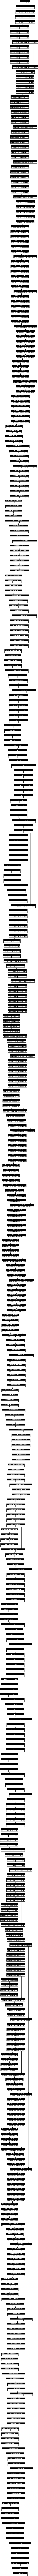

In [41]:
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [42]:
def get_student_model(input_shape=(224, 224, 1), num_classes=3):
    base = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights=None
    )
    x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
    x = tf.keras.layers.Dropout(0.2)(x)
    out = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=base.input, outputs=out)

In [43]:
def distillation_loss(y_true, y_pred, teacher_pred, temperature=4):
    soft_teacher = tf.nn.softmax(teacher_pred / temperature)
    soft_student = tf.nn.log_softmax(y_pred / temperature)
    loss = tf.reduce_mean(tf.keras.losses.KLDivergence()(soft_teacher, soft_student))
    return loss

In [44]:
# Get teacher predictions
teacher_pred = teacher_model.predict(x_batch)

# Get student predictions
with tf.GradientTape() as tape:
    student_pred = student_model(x_batch)
    loss = distillation_loss(y_true, student_pred, teacher_pred)

# Apply gradients
gradients = tape.gradient(loss, student_model.trainable_variables)
optimizer.apply_gradients(zip(gradients, student_model.trainable_variables))


NameError: name 'teacher_model' is not defined